# Notes


# Imports

In [14]:
import numpy as np
import h5py
import time
import glob
import matplotlib.pyplot as plt
%load_ext autoreload
import os
%autoreload 2
import sys
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Layout, AppLayout
from ipywidgets import Video, Image, VBox, Text
import ipywidgets as widgets
from sidecar import Sidecar


# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from coordinate_transformations import CoordTransformer_14D_PP
from correlation_functions import cross_correlation, angular_cross_correlation

from coordinate_transformations import compute_14D_rep_from_trajectories
from coordinate_transformations import project_14D_rep_onto_modes

# # adding the infomap libs
# from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
# from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
# from infomap_utils import make_binTuple_to_clusterIdx_dict
# from post_processing import contiguous_regions
# from post_processing import process_1D_timeseries



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the main data

In [2]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]


# Compute the 14D timeseries data

In [3]:
pca_savepath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'PCA_data/main.h5')
pca_savepath

'/media/liam/hd1/fighting_data/PCA_data/main.h5'

In [4]:
# ---- create a master trajectory to use -----#
#
# We could use all exps, but this is slow, and the result doesnt change.
exp_idxs_to_use = np.unique(fight_bout_info_noDurThresh[:,0])[:]
exp_idxs_to_use

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19,
       20])

In [5]:
combined_trajectories = []

for expIdx in exp_idxs_to_use:
    
    smooth_traj = np.copy(smooth_trajectories[expIdx])
    
    # make sure winner is first
    winnerIdx = winner_idxs[expIdx]
    if winnerIdx != 0:
        smooth_traj = smooth_traj[:, ::-1]
    combined_trajectories.append(smooth_traj)
    
combined_trajectories = np.concatenate(combined_trajectories)

numFrames_combined, numFish, numBodyPoints, _ = combined_trajectories.shape


# finally we set winnerIdx=0, since we enforced this
winnerIdx=0

## save

In [7]:
# ------ compute and save the PCA ---- #
t0 = time.perf_counter()

# Compute and save
coord_handler = CoordTransformer_14D_PP(combined_trajectories, winnerIdx)
with h5py.File(pca_savepath, 'w') as hf:
    hf.create_dataset('trajectories', data=coord_handler.trajectories)
    hf.create_dataset('rep_14D_tseries', data=coord_handler.rep_14D_tseries)
    hf.create_dataset('mean_14D_rep', data=coord_handler.mean_rep)
    hf.create_dataset('covmat', data=coord_handler.covmat)
    hf.create_dataset('eigvals', data=coord_handler.eigvals)
    hf.create_dataset('eigvecs', data=coord_handler.eigvecs)
    hf.create_dataset('pca_tseries', data=coord_handler.pca_tseries)
    hf.create_dataset('cum_var_explained', data=coord_handler.cum_var_explained)
    hf.create_dataset('winnerIdx', data=coord_handler.winnerIdx)


tE = time.perf_counter()
print(tE-t0, ' s')

1802.342042954173  s


## load

In [6]:
# Load
with h5py.File(pca_savepath, 'r') as hf:
    
    trajectories = hf['trajectories'][:]
    rep_14D_tseries = hf['rep_14D_tseries'][:]
    mean_14D_rep = hf['mean_14D_rep'][:]
    covmat = hf['covmat'][:]
    eigvals = hf['eigvals'][:]
    eigvecs = hf['eigvecs'][:]
    pca_tseries = hf['pca_tseries'][:]
    cum_var_explained = hf['cum_var_explained'][:]
    winnerIdx = hf['winnerIdx'][()]

coord_handler = CoordTransformer_14D_PP(trajectories, winnerIdx,
                             rep_14D_tseries=rep_14D_tseries)


# Panel A

In [9]:
numProjectionModes = 14
projection_eig_vecs = np.copy(eigvecs[:, :numProjectionModes])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
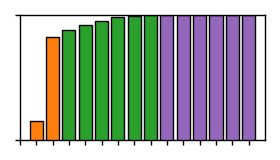

In [34]:
 # ---- Variance explained --- #

# get the dimension of the timeseries
dim = covmat.shape[0]

# get the xvalues for plotting (non zero indexed)
x_vals = np.arange(1,dim+1)
x_text_vals = [' ', "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14"]

# make the plot
fig, ax = plt.subplots(1,1, figsize=(2.8,1.6))

bar_list = ax.bar(x_vals, cum_var_explained, alpha=1)
ax.set_title('', fontdict={'fontsize':15})

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xlim(0,len(x_text_vals))
ax.set_xticks(np.arange(len(x_text_vals)))
ax.set_xticklabels([])

ax.set_ylim(0.5, 1)
ax.set_yticks([0.5, 1])
ax.set_yticklabels([])

# set the colors
c1 = "C1"
c2 = "C2"
c3 = "C4"


# now set the colors
for i in range(2):
    bar_list[i].set_color(c1)
    bar_list[i].set_edgecolor("black")
for i in range(2,8):
    bar_list[i].set_color(c2)
    bar_list[i].set_edgecolor("black")
for i in range(8, 14):
    bar_list[i].set_color(c3)
    bar_list[i].set_edgecolor("black")
    
# dummy lines for legend
ax.plot(np.NaN, np.NaN, '-', color=c1, label='                             ')
ax.plot(np.NaN, np.NaN, '-', color=c2, label='     ')
ax.plot(np.NaN, np.NaN, '-', color=c3, label='     ')

# The spines
plt.setp(ax.spines.values(), linewidth=1)
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/fig2_A.png', dpi=300, transparent=True, bbox_inches='tight')

# Examine the modes

## Make the widgets to hold the data

In [77]:
### Prepare the list of widgets ###
numFish=2
numBodyPoints=3

# layout parameters
number_layout = widgets.Layout(width='70px')
text_layout = widgets.Layout(width='120px')

# preallocate list structures to hold the numbers
plottable_3D_widget_list = [ [[[] for _ in range(3)] for _ in range(numBodyPoints)] for _ in range(numFish)]
pca_widget_list = [ [] for i in range(14)]
rep_widget_list = [ [] for i in range(14)]

# get the plottable positions for the frame
#plottable_positions = rep14D_to_plotable_positions(mean_14D_rep)
plottable_positions = coord_handler.convert_rep14D_to_plotable_positions(coord_handler.mean_rep)

# grab the plottable values
for fishIdx in range(numFish):
    for bpIdx in range(numBodyPoints):
        for dimIdx in range(3):
             
            # plottable data
            wid_val = np.round(np.copy(plottable_positions[fishIdx, bpIdx, dimIdx]), 2)
            val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
            plottable_3D_widget_list[fishIdx][bpIdx][dimIdx] = val_widge_3D
            
# grab the pca values
mean_rep_modes = coord_handler.convert_rep14D_to_mode_weights(coord_handler.mean_rep)
for pcIdx in range(14):
    wid_val = np.round(np.copy(mean_rep_modes[pcIdx]), 2)
    val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
    pca_widget_list[pcIdx] = val_widge_3D
    
# grab the rep values
for pcIdx in range(14):
    wid_val = np.round(np.copy(coord_handler.mean_rep[pcIdx]), 2)
    val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
    rep_widget_list[pcIdx] = val_widge_3D

In [78]:
### Make widgets to vizualize the plottable positions


# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')

# widget lists
f_bp_XYZ_boxes = [None]*numFish
f_3D_wid_titles = [None]*numFish
f_3D_wids = [None]*numFish

for fishIdx in range(numFish):
    f_bp_box_list = []
    for bpIdx in range(numBodyPoints):
        f_bp_XYZ_boxes[fishIdx] = widgets.HBox(plottable_3D_widget_list[fishIdx][bpIdx][:], layout=widgets.Layout(padding=('0px 30px 0 0')))
        f_bp_box_list.append(f_bp_XYZ_boxes[fishIdx])
    f_3D_wid_titles[fishIdx] = widgets.Text('Fish{} FC bps'.format(fishIdx+1), layout=text_layout)
    f_3D_wids[fishIdx] = widgets.VBox([f_3D_wid_titles[fishIdx]]+f_bp_box_list)

# Final widget
plottable_frame_widget = widgets.HBox(f_3D_wids, layout=widgets.Layout(padding=('0px 0px 30px 200px')))

In [79]:
### Make widgets to vizualize the pca_data

# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')
wid_title = widgets.Text('mode weights', layout=text_layout)

# get the values of the widget in a hbox
mode_weight_vals_wid = widgets.HBox(pca_widget_list, layout=widgets.Layout(padding=('0px 0px 00px 000px')))

# make the final widget with title
mode_frame_widget = widgets.VBox([wid_title, mode_weight_vals_wid], layout=widgets.Layout(padding=('0px 0px 30px 200px')))


### Make widgets to vizualize the rep_data

# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')
wid_title = widgets.Text('14D rep', layout=text_layout)

# get the values of the widget in a hbox
rep_vals_wid = widgets.HBox(rep_widget_list, layout=widgets.Layout(padding=('0px 0px 00px 000px')))

# make the final widget with title
rep_frame_widget = widgets.VBox([wid_title, rep_vals_wid], layout=widgets.Layout(padding=('0px 0px 30px 200px')))

In [80]:
# final widget


data_widget = widgets.VBox([plottable_frame_widget, mode_frame_widget, rep_frame_widget],
                                    layout=widgets.Layout(display="flex-start"))

#data_widget

## Make the 3D plotting widget

Canvas(header_visible=False, layout=Layout(height='100%', width='100%'), toolbar=Toolbar(toolitems=[('Home', '…
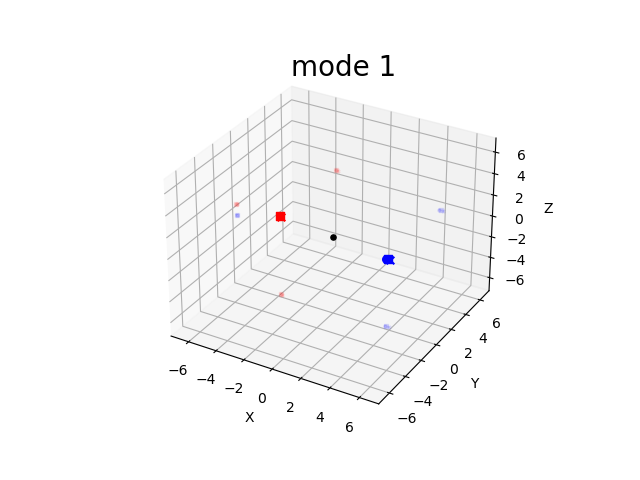

In [81]:
#  ----------------- make a 3D plot of the positions ----------------------- #

plt.ion()


rep_data = np.copy(coord_handler.mean_rep)
pca_data = coord_handler.convert_rep14D_to_mode_weights(rep_data)
frame_positions = coord_handler.convert_rep14D_to_plotable_positions(rep_data)

numFish, numBodyPoints = 2, 3
fish_colors = ['red', 'blue']

# Attaching 3D axis to the figure
fig = plt.figure()
fig.tight_layout()
fig.canvas.header_visible = False
#fig.canvas.layout.min_height = '400px'
fig.canvas.layout.height = '100%'
fig.canvas.layout.width = '100%'
ax = fig.add_subplot(111, projection='3d')  
#fig.suptitle('Investigating PCA mode action about mean configuration')
#ax = p3.Axes3D(fig, [0.,0.,1.,1.])


# create a widget to hold the title of the slide
#text_title_widget = widgets.FloatText(value=0)
title_font = {'fontname':'Arial', 'size':'20'}
title_text = ax.text2D(0.4, 0.95, "mode 1", transform=ax.transAxes, **title_font)


# set the limits
xmin, xmax = -7, 7
ymin, ymax = -7, 7
zmin, zmax = -7, 7

# Setting the axes properties
ax.set_xlim3d([xmin, xmax])
ax.set_xlabel('X')

ax.set_ylim3d([ymin, ymax])
ax.set_ylabel('Y')

ax.set_zlim3d([zmin, zmax])
ax.set_zlabel('Z')

# Initialize scatters (list over fish, list over bps)
symbols = ['o', 's', 'x']
sizes=30

# Main scatters
scatters = []
for fishIdx in range(numFish):
    col = fish_colors[fishIdx]
    fish_scatters = []
    for bpIdx in range(numBodyPoints):
        fish_scatters.append(ax.scatter(frame_positions[fishIdx, bpIdx, 0], 
                                        frame_positions[fishIdx, bpIdx, 1], 
                                        frame_positions[fishIdx, bpIdx, 2], 
                                        c=col, s=sizes, marker=symbols[bpIdx])) 
    scatters.append(fish_scatters)
    
# Main lines
lines = []
for fishIdx in range(numFish):
    col = fish_colors[fishIdx]
    line = ax.plot(frame_positions[fishIdx, :, 0], frame_positions[fishIdx, :, 1], frame_positions[fishIdx, :, 2], c=col)[0]
    lines.append(line)
    
# scatterplot the origin
ax.scatter(0, 0, 0, c='black', s=14)
        
sizes=5

scatter_projections = []
lines_projections = []
for projectionIdx in range(3):
        
    # XZ => Y
    if projectionIdx == 0:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 1] = ymax
    # XY => Z
    elif projectionIdx == 1:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 2] = zmin
    # YZ => X
    elif projectionIdx == 2:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 0] = xmin
    
    proj_scatters = []
    proj_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        # scatter plots
        fish_scatters = []
        for bpIdx in range(numBodyPoints):
            #print(symbols[bpIdx])
            fish_scatters.append(ax.scatter(projectionData[fishIdx, bpIdx, 0], projectionData[fishIdx, bpIdx, 1], projectionData[fishIdx, bpIdx, 2], 
                                            c=col, s=sizes, marker=symbols[bpIdx], alpha=0.1))
        # lines
        line = ax.plot(projectionData[fishIdx, :, 0], projectionData[fishIdx, :, 1], projectionData[fishIdx, :, 2], c=col, alpha=0.1)[0]
        proj_lines.append(line)
        proj_scatters.append(fish_scatters)

    scatter_projections.append(proj_scatters)
    lines_projections.append(proj_lines)
    
    
    
    
    
# make the widget
layout = widgets.Layout(width='100%')
plot_widget = VBox([fig.canvas], layout=layout)

In [82]:
# make a title text widget, and link it to the text of the 3D plot
text_title_widget = widgets.FloatText(value=0)
def text_title_on_change(change):
    title_text.set_text('mode {0}'.format(int(change.new+1)))
text_title_widget.observe(text_title_on_change)

## Slider widgets

In [83]:
# make the 8 sliders
numModeSliders = 14

mode_sliders = []

for ii in range(numModeSliders):
    
    # get the slider ranges and step
    if ii == 6:
        slider_min = -5
        slider_max = 5
        step=0.01
        init_val = pca_widget_list[ii].value
    elif ii == 7:
        slider_min = -5
        slider_max = 5
        step=0.01
        init_val = pca_widget_list[ii].value
    else:
        slider_min = np.nanmin(pca_tseries[:,ii])
        slider_max = np.nanmax(pca_tseries[:,ii])
        step=0.01
        init_val = pca_widget_list[ii].value
        
    # make the slider
    mode_slider = widgets.FloatSlider(value=init_val, min=slider_min, max=slider_max, step=step, 
                                         continuous_update=True, description='m{0}: {1}'.format(ii+1, np.round(mean_rep_modes[ii],2)), 
                                          layout=Layout(width='100%', height='50px'))
    
    # link the slider to the widget display values
    mode_val_slider_link = widgets.link((mode_slider, 'value'), (pca_widget_list[ii], 'value'))
    
    # keep the mode slider
    mode_sliders.append(mode_slider)
    
    
    
    
# ------- On changes to the mode sliders, update the plottable positions ------ #

def update_plottable_from_mode_sliders(change):
    numCams=3
    numFish=2
    numBodyPoints=3
    
    #title_text.set_text(str(change))
    
    # get the current values of the mode weights
    pca_data = []
    for ii in range(numModeSliders):
        pca_weight = pca_widget_list[ii].value
        pca_data.append(pca_weight)
    frame_pca_data = np.array(pca_data)
    
    # get the representation data from the pca weights
    #frame_rep_data = modes_to_14D_rep(frame_pca_data, mean_14D_rep, sorted_eig_vecs)
    frame_rep_data = coord_handler.convert_mode_weights_to_14D_rep(frame_pca_data)
    
    # get the plottable positions
    #frame_positions = rep14D_to_plotable_positions(frame_rep_data)
    frame_positions = coord_handler.convert_rep14D_to_plotable_positions(frame_rep_data)
    
    # update the rep data
    for ii in range(14):
        rep_widget_list[ii].value = np.round(frame_rep_data[ii],3)
        
    # update the plottable positions (lab can't be updated)
    for fishIdx in range(numFish):
        for bpIdx in range(numBodyPoints):
            for dimIdx in range(3):
                plottable_3D_widget_list[fishIdx][bpIdx][dimIdx].value = np.round(frame_positions[fishIdx, bpIdx, dimIdx],3)
            
    
for ii in range(numModeSliders):
    mode_sliders[ii].observe(update_plottable_from_mode_sliders, names='value')
    
    
# all sliders
all_sliders = widgets.VBox([widgets.VBox(mode_sliders)])



# ----- Update the plot with mode sliders ----- #


def update_plot_mode_change(change):
    numFish=2
    numBodyPoints=3
    #fig.suptitle('Investigating PCA mode action about mean configuration')
    
    #------ Gather the current frame positions from the widget --- #
    frame_positions = []
    for fishIdx in range(numFish):

        fish_position = []
        for bpIdx in range(numBodyPoints):

            bodypoint_pos = []
            for dimIdx in range(3):
                val = plottable_3D_widget_list[fishIdx][bpIdx][dimIdx].value
                bodypoint_pos.append(val)
            bodypoint_pos = np.array(bodypoint_pos)

            fish_position.append(bodypoint_pos)
        fish_position = np.stack(fish_position)

        frame_positions.append(fish_position)
    frame_positions = np.stack(frame_positions)
    #-------------------------------------#
        
        
    #------- Update the real fish ---- #
    # update the scatters
    for fishIdx in range(numFish):
        for bpIdx in range(numBodyPoints):
            ax = scatters[fishIdx][bpIdx]
            ax._offsets3d[0][0] = frame_positions[fishIdx, bpIdx, 0]
            ax._offsets3d[1][0] = frame_positions[fishIdx, bpIdx, 1]
            ax._offsets3d[2][0] = frame_positions[fishIdx, bpIdx, 2]
            
    # update the lines
    for fishIdx,line in enumerate(lines):
            line.set_data(frame_positions[fishIdx, :, :2].swapaxes(0,1))
            line.set_3d_properties(frame_positions[fishIdx, :, 2])
    #--------------------------------------#
    
    
    
    # -------  Update the projections  ------- #
    for projectionIdx in range(3):
        
        # XZ => Y=0
        if projectionIdx == 0:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 1] = ymax
        # XY => Z=0
        elif projectionIdx == 1:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 2] = zmin
        # YZ => X=0
        elif projectionIdx == 2:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 0] = xmin
            
        proj_scatters = scatter_projections[projectionIdx]
        proj_lines = lines_projections[projectionIdx]
        
        # update the scatters
        for fishIdx in range(numFish):
            for bpIdx in range(numBodyPoints):
                ax = proj_scatters[fishIdx][bpIdx]
                ax._offsets3d[0][0] = projectionData[fishIdx, bpIdx, 0]
                ax._offsets3d[1][0] = projectionData[fishIdx, bpIdx, 1]
                ax._offsets3d[2][0] = projectionData[fishIdx, bpIdx, 2]

        # update the lines
        for fishIdx,line in enumerate(proj_lines):
            line.set_data(projectionData[fishIdx, :, :2].swapaxes(0,1))
            line.set_3d_properties(projectionData[fishIdx, :, 2])
        
         
    fig.canvas.draw()
    fig.canvas.flush_events()


for ii in range(numModeSliders):
    ms = mode_sliders[ii]
    ms.observe(update_plot_mode_change, names='value')


## Main Investigation

In [84]:
# display Vbox
plt.ion()
sc = Sidecar(title='Sidecar Output')
with sc:
    display(all_sliders)
    #display(mean_rep_modes)

In [85]:
mode_names = ["X' distance", "Z' distance", 
              "'chasing'", "'anti-parallel display'", "'parallel display'", " 'face-off'", "symmetric pitching", "asymmetric pitching",
              " head & tail X' motion ", " head & tail Y' motion ",
              " head Y' motion", "pec Z' motion"
              " pec X' motion ", "pec Z' motion "
             ]

In [86]:
plot_widget

In [67]:
#plt.savefig('/home/liam/fish_analysis/nugget_dump/20210209/m3_right_peak.png')

In [22]:
# reset all the sliders
for modeIdx in range(len(pca_widget_list)):
    pca_widget_list[modeIdx].value = 0

## animating the PCA modes

In [87]:
# create a value array for pulses

def compute_modeval_array(minval, maxval, step):
    ''' 0 -> max -> min -> 0
    
    minval, maxval are inclusive
    '''
    first_leg = np.arange(0, maxval+step, step)
    second_leg = np.arange(minval, maxval, step)[::-1]
    third_leg = np.arange(minval+step, 0+step, step)
    modeval_arr = np.concatenate([first_leg, second_leg, third_leg])
    return modeval_arr

modeval_arr = compute_modeval_array(-3, 3, 0.5)
modeval_arr

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  2.5,  2. ,  1.5,  1. ,
        0.5,  0. , -0.5, -1. , -1.5, -2. , -2.5, -3. , -2.5, -2. , -1.5,
       -1. , -0.5,  0. ])

In [88]:
# create a list for each pc

pc_modeval_arr_list = []

# pc1
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc2
modeval_arr = compute_modeval_array(-10, 10, 1)
pc_modeval_arr_list.append(modeval_arr)



# pc3
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc4
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc5
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc6
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)


# pc7
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc8
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)



# pc9
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc10
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc11
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc12
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc13
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

# pc14
modeval_arr = compute_modeval_array(-5, 5, 1)
pc_modeval_arr_list.append(modeval_arr)

In [89]:
text_title_widget.value = 0

In [90]:
# pulse the top two modes in turn

time.sleep(10)

modeval_arr = compute_modeval_array(-5, 5, 0.5)

for modeIdx in (0, 1):
    modeval_arr = pc_modeval_arr_list[modeIdx]
    text_title_widget.value = modeIdx
    for val in modeval_arr:
        pca_widget_list[modeIdx].value = val
        time.sleep(0.01)
        
time.sleep(1)
        
for modeIdx in (2, 3, 4, 5, 6, 7):
    modeval_arr = pc_modeval_arr_list[modeIdx]
    text_title_widget.value = str(modeIdx)
    for val in modeval_arr:
        pca_widget_list[modeIdx].value = val
        time.sleep(0.01)
        
# time.sleep(1)
            
# for modeIdx in (8, 9, 10, 11, 12, 13):
#     modeval_arr = pc_modeval_arr_list[modeIdx]
#     text_title_widget.value = str(modeIdx)
#     for val in modeval_arr:
#         pca_widget_list[modeIdx].value = val
#         time.sleep(0.05)
        

# Compute kin vars for all experiments

In [8]:
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from kinematics import compute_pec_pec_distance_dot, compute_coordinate_origin_z_dot

In [9]:
interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording

In [10]:
t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

exp_phi_dots = []
exp_dpp_dots = []
exp_pec_z_differences = []
exp_Oz_dots = []


for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    raw_traj = raw_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
    
    phi_dot = compute_phi_dot_from_raw_trajectories(raw_traj, winIdx, losIdx, dt=dt,
                                                    interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                                    smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_phi_dots.append(phi_dot)
    
    
    signed_pec_z_difference = compute_signed_pec_z_difference(smooth_traj, winIdx, losIdx)
    exp_pec_z_differences.append(signed_pec_z_difference)
    
    dpp_dot = compute_pec_pec_distance_dot(raw_traj,  dt=dt,
                                            interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                            smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_dpp_dots.append(dpp_dot)
    
    
    Oz_dot = compute_coordinate_origin_z_dot(raw_traj, winIdx, losIdx, dt=dt,
                                             interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd, 
                                             smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_Oz_dots.append(Oz_dot)
    
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200129_140656


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_153857


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_181614


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200207_161445


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200213_154940


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200214_153519


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200217_160052


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200218_153008


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200316_163320


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200327_154737


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200330_161100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200331_162136


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200520_152810


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200521_154541


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200525_161602


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]
/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200828_155504


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200902_160124


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200903_160946


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]



finished: 19.189300617668778 s


In [14]:
# --- Master sets of plotting --- #
dpp_dot_master = np.concatenate(exp_dpp_dots)
phi_dot_master = np.concatenate(exp_phi_dots)
pec_z_difference_master = np.concatenate(exp_pec_z_differences)
Oz_dots_master = np.concatenate(exp_Oz_dots)

dpp_master = np.concatenate(exp_dpps)
tetW_master = np.concatenate(exp_tetWs)
tetL_master = np.concatenate(exp_tetLs)




# compute the autocorrs for a single experiment, for 5s lags

In [17]:
expIdx = 12
expNames[expIdx]

'FishTank20200331_162136'

In [18]:
t0 = time.perf_counter()  

# make sure winner is first
smooth_traj = np.copy(smooth_trajectories[expIdx])
winnerIdx = winner_idxs[expIdx]

# compute the 14D rep for the experiment
exp_14D_rep = compute_14D_rep_from_trajectories(smooth_traj, winnerIdx)

# create the mode timeseries
exp_mode_ts = project_14D_rep_onto_modes(exp_14D_rep, coord_handler.eigvecs, numProjectionModes=14)


tE = time.perf_counter()
print(tE-t0, ' s')

98.86740110162646  s


In [19]:
# get the dpp,tetW,tetL data
dpp = exp_dpps[expIdx]
tetW = exp_tetWs[expIdx]
tetL = exp_tetLs[expIdx]

In [32]:
# ----- correlations ----- #
t0 = time.perf_counter()


maxLag=5000
numSamples=50000
min_numSamples_allowed=10000


pca_lag_results = []
for pcIdx in range(exp_mode_ts.shape[1]):
    ts = exp_mode_ts[:,pcIdx]
    lag_sizes, lag_results = cross_correlation(ts, ts, maxLag=maxLag, numSamples=numSamples, min_numSamples_allowed=min_numSamples_allowed)
    pca_lag_results.append(lag_results)
    print(pcIdx, ' done')
    

dpp_lag_sizes, dpp_lag_results = cross_correlation(dpp, dpp, maxLag=maxLag, numSamples=numSamples, min_numSamples_allowed=min_numSamples_allowed)
print('dpp done')

tetW_lag_sizes, tetW_lag_results = angular_cross_correlation(tetW, tetW, maxLag=maxLag, numSamples=numSamples, min_numSamples_allowed=min_numSamples_allowed)
print('tetW done')

tetL_lag_sizes, tetL_lag_results = angular_cross_correlation(tetL, tetL, maxLag=maxLag, numSamples=numSamples, min_numSamples_allowed=min_numSamples_allowed)
print('tetL done')
    

tE = time.perf_counter()
print(tE-t0)


0  done
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done
13  done
dpp done
tetW done
tetL done
2725.5124695110135


# Panel B

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
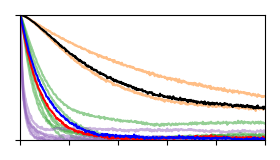

In [35]:
t0 = time.time()

# set up the figure
# 2.8,1.6
fig, axs = plt.subplots(figsize=(2.8,1.6)) #plt.subplots(figsize=(16,6))


# make the color-list
color_list = []
for i in range(2):
    color_list.append(c1)
for i in range(2,8):
    color_list.append(c2)
for i in range(8, 14):
    color_list.append(c3)
    
    
# use the one set of lags
lags = lag_sizes[5000:]


# plot all the autocorrelations
for i in range(14):
    pca_cc = pca_lag_results[i]
    axs.plot(lags, pca_cc[5000:], color=color_list[i], lw=1.5, alpha=0.5)
    
    
    
# plot the new vars
axs.plot(lags, dpp_lag_results[5000:], color='black', lw=1.5)
axs.plot(lags, tetW_lag_results[5000:], color='red', lw=1.5)
axs.plot(lags, tetL_lag_results[5000:], color='blue', lw=1.5)

# set x axis params
xticks = [0,100,200,300,400,500]
xtick_labels = []
axs.set_xticks(xticks)
axs.set_xticklabels([])
axs.set_xlim(0, 500)
    



# set y axis params
axs.set_ylim((0,1))
axs.set_yticks([0, 1])
axs.set_yticklabels([])


# The spines
plt.setp(ax.spines.values(), linewidth=1)
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)


# save and finish
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/fig2_B.png', dpi=300, transparent=True, bbox_inches='tight')


# tE = time.time()
# print(tE-t0)